In [1]:
# Primary modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Other modules / functions
import pickle
import os
import matplotlib.gridspec as gridspec

# For inline plotting
%matplotlib inline
plt.ion()

In [2]:
# Import suftware (use development copy)
import sys
sys.path.append('../../suftware')

import suftware as sw

In [3]:
# Set default plotting style
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rc('text', usetex=True)
fontsize=7
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['hatch.color'] = 'black'

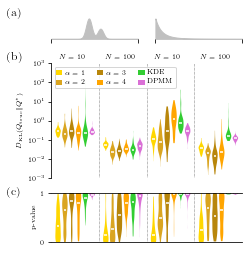

In [4]:
# Create figure
fig = plt.figure(figsize=[3.4,3.4])

# Load geodesic distances for 3 distributions
sim_dir = 'simulations_final/fig2_figS3/'

df_klds = pd.DataFrame()
df_pvs = pd.DataFrame()
for i, distribution_name in enumerate(['DoubleGaussian','Pareto']):
    
    # Load KL divergences
    klds_filename = '%s/df_KL_divergences_%s.pkl'%(sim_dir,distribution_name)
    tmp_df_klds = pickle.load(open(klds_filename,'rb'), encoding='latin1')
    
    # Load p-values
    pvals_filename = '%s/df_p_values_%s.pkl'%(sim_dir,distribution_name)
    tmp_df_p_values = pickle.load(open(pvals_filename,'rb'), encoding='latin1')
    
    # Change column names
    new_columns = []
    for N in [10,100]:
        for alpha in [1,2,3,4]:
            new_columns.append('%s $\\alpha=%d$ %d'%(distribution_name, alpha, N))
        new_columns.append('%s KDE %d'%(distribution_name, N))
        new_columns.append('%s DPMM %d'%(distribution_name, N))
    tmp_df_klds.columns = new_columns
    tmp_df_p_values.columns = new_columns
    
    # Concatenate dataframes
    df_klds = pd.concat([df_klds,tmp_df_klds],axis=1)
    df_pvs = pd.concat([df_pvs,tmp_df_p_values],axis=1)
    
    #
    # Plot Q_true
    #
    gs = gridspec.GridSpec(1, 2, top=.95, bottom=0.85, right=.98, left=.20, wspace=.2)
    ax = plt.subplot(gs[0, i])
    
    # Simulate density with given name
    dist = sw.SimulatedDensity(name=distribution_name)
    xmin, xmax = dist.bounding_box
    xs = np.linspace(xmin,xmax,1000)
    ys = dist.evaluate(xs)
    ax.set_ylim([0,1.2*max(ys)])
    ax.set_yticks([])
    ax.set_xlim(dist.bounding_box)
    ax.set_xticks(dist.bounding_box)
    ax.set_xticklabels([])
    ax.fill_between(xs,ys,0,color='silver')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axhline(0,linestyle='--',color='k',linewidth=.5)
    
#
# Plot KL divergences
#

# Set axes
gs = gridspec.GridSpec(1, 1, top=.75, bottom=0.28, right=.98, left=.20, wspace=.2)
ax = plt.subplot(gs[0, 0])

# Fix geometry of geodesic distance
num_cols = len(df_klds.columns)
klds_xs = np.arange(num_cols).astype(float)
klds_xs += 2+1*np.floor(klds_xs/6)   

# Set colors
color_pairs = [
    ('$\\alpha=1$','gold'),
    ('$\\alpha=2$','goldenrod'), 
    ('$\\alpha=3$','darkgoldenrod'),
    ('$\\alpha=4$','orange'),
    ('KDE','limegreen'),
    ('DPMM','orchid')
]
color_dict = dict(color_pairs)

# Make violinplots
colors = [c[1] for c in color_pairs]*4
parts = ax.violinplot(np.log10(df_klds.T), 
                      positions=klds_xs, 
                      widths=.8, 
                      showmedians=True, 
                      showextrema=False);

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(1)
parts['cmedians'].set_color('white')

#Draw vertical lines
vline_xs = 0.5*klds_xs[[5,11,17]] + 0.5*klds_xs[[6,12,18]]
for vline_x in vline_xs:
    ax.axvline(vline_x, linestyle=':', color='k', linewidth=.5)

# Show N=XXX along x-axis
xlim = [min(klds_xs)-1, max(klds_xs)+1]
ax.set_xlim(xlim)
xtick_indices = np.arange(2,num_cols,6)
xticks = klds_xs[xtick_indices]
ax.set_xticks(xticks)
ax.set_xticklabels(['$N=%s$'%df_klds.columns[i].split()[2] for i in xtick_indices])
ax.xaxis.tick_top()
ax.tick_params(axis='x', direction='in', length=0, width=0)

# y-axis and legend
yticks = list(range(-3,4))
ylim = [min(yticks),max(yticks)]
yticklabels = ['$10^{%d}$'%y for y in yticks]
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
for key, color in color_pairs:
    ax.plot([-10, -11], [1, 1], '-',color=color, label=key, linewidth=5)
ax.legend(ncol=3, loc='upper left', handlelength=.25)
ax.set_ylabel('$D_\mathrm{KL}(Q_\mathrm{true}\|Q^*)$')

# Other styling
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False) 
ax.spines['right'].set_visible(False) 

#
# Plot p-values
#

# Set axes
gs = gridspec.GridSpec(1, 1, top=.22, bottom=0.02, right=.98, left=.20, wspace=.2)
ax = plt.subplot(gs[0, 0])

num_cols = len(df_pvs.columns)
pvs_xs = klds_xs

# Make violinplots
colors = [c[1] for c in color_pairs]*4
pvs = df_pvs.T
m,n = pvs.shape
noise = 0.05*(np.random.rand(m,n)-.5)
parts = ax.violinplot(df_pvs.T + noise, 
                      positions=pvs_xs, 
                      widths=.8, 
                      showmedians=True, 
                      showextrema=False);
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(1)
parts['cmedians'].set_color('white')

# x-axis
ax.set_xlim(xlim)
ax.set_xticks([])
for vline_x in vline_xs:
    ax.axvline(vline_x, linestyle=':', color='k', linewidth=.5)

# y-axis
ax.set_ylim([0,1])
ax.set_yticks([0,1])
ax.set_ylabel('p-value')


# Other styling
ax.spines['top'].set_visible(True) 
ax.spines['bottom'].set_visible(True) 
ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 

# Label figure
plt.figtext(.02, .98, '(a)', horizontalalignment='left', verticalalignment='top', fontsize=12)
plt.figtext(.02, .80, '(b)', horizontalalignment='left', verticalalignment='top', fontsize=12)
plt.figtext(.02, .25, '(c)', horizontalalignment='left', verticalalignment='top', fontsize=12)
    
plt.show()
fig.savefig('figures/fig_2.pdf')